# Station Map

In [1]:
from obspy import *
from numpy import * 
from pandas import *
from os import listdir 

import netCDF4 as nc
import pygmt
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [12]:
config = {}

config['workdir'] = "/export/data/LNM/data/"

config['datadir'] = config['workdir']+"2018/"
config['files'] = listdir(config['datadir'])

config['plot_station'] = "all"

config['outdir_figures'] = "/home/brotzer/Documents/ROMY/LowNoiseModel/figures/"

config['outdir'] = config['workdir']

In [3]:
def __read_stats_nc(config):

    stations = DataFrame(columns=['station_id', 'name', 'latitude', 'longitude'])

    errors = []

    for file in config['files']:

        try:
            print(f"\nreading {config['datadir']}{file}")

            f = nc.Dataset(str(config['datadir'])+str(file),'r')

        #     for key in f.variables.keys():
        #            print(key)

            station_id = f.variables['trace_id'][:]
            latitude = f.variables['lat'][:]
            longitude = f.variables['lon'][:]
            name = str(str(station_id).split(".")[1])

            ## assimilate row
            tmp_row = Series([str(station_id[0]), name, latitude, longitude], index=stations.columns)

            ## add row to Dataframe
            stations = stations.append(tmp_row, ignore_index=True)

            f.close()

        except:
            errors.append(f"{config['datadir']}{file}")


    if len(errors) > 1:
        for error in errors:
            print(error)
        print(f"\n failed to read {len(errors)} / {len(config['files'])}")

    return stations

In [4]:
stations = __read_stats_nc(config)


reading /export/data/LNM/data/2018/ESACCI-SEASTATE-L2-MSSPEC-II_TAU_LHZ_10_2018-fv01.nc

reading /export/data/LNM/data/2018/ESACCI-SEASTATE-L2-MSSPEC-IU_QSPA_LHZ_80_2018-fv01.nc

reading /export/data/LNM/data/2018/ESACCI-SEASTATE-L2-MSSPEC-IU_SSPA_LHZ_00_2018-fv01.nc

reading /export/data/LNM/data/2018/ESACCI-SEASTATE-L2-MSSPEC-IU_TARA_LHZ_10_2018-fv01.nc

reading /export/data/LNM/data/2018/ESACCI-SEASTATE-L2-MSSPEC-IU_WAKE_LHZ_00_2018-fv01.nc

reading /export/data/LNM/data/2018/ESACCI-SEASTATE-L2-MSSPEC-II_RPN_LHZ_00_2018-fv01.nc

reading /export/data/LNM/data/2018/ESACCI-SEASTATE-L2-MSSPEC-IU_XMAS_LHZ_10_2018-fv01.nc

reading /export/data/LNM/data/2018/ESACCI-SEASTATE-L2-MSSPEC-IU_SFJD_LHZ_10_2018-fv01.nc

reading /export/data/LNM/data/2018/ESACCI-SEASTATE-L2-MSSPEC-II_JTS_LHZ_00_2018-fv01.nc

reading /export/data/LNM/data/2018/ESACCI-SEASTATE-L2-MSSPEC-II_FFC_LHZ_00_2018-fv01.nc

reading /export/data/LNM/data/2018/ESACCI-SEASTATE-L2-MSSPEC-II_EFI_LHZ_00_2018-fv01.nc

reading /expor

In [27]:
def __makeplot_map(config, stations, station_names=True):

    topo_data = '@earth_relief_06m'

    # minlon, maxlon, minlat, maxlat = (-180, 180, -70, 70)


    fig = pygmt.Figure()

    pygmt.config(FONT_ANNOT="8p,Helvetica,black")
    pygmt.config(FONT_LABEL="8p,Helvetica,black")

    reg  = 'g' # [minlon, maxlon, minlat, maxlat]
    proj = "Kf0/10c"

    # make color pallets
    pygmt.makecpt(
        cmap='geo',
        series='-8000/8000/1000',
        continuous=True,
    )

    fig.grdimage(
        grid=topo_data,
        region=reg,
        projection=proj,
        shading=True,
        frame=False,
    )

    fig.coast(
        region=reg,
        projection=proj,
        shorelines=True,
        frame=["WSNE","af"],
        resolution="c",
    )

    if config['plot_station'] is not 'all':
        stations = stations[stations['name'] == config['plot_station']]
        if stations.empty:
            print(f"\n -> station {config['plot_station']} not found ! Aborting...")
            exit()
            
#     for i, station in stations.iterrows():
    fig.plot(
        x=stations['longitude'].astype(float),
        y=stations['latitude'].astype(float),
        style='t0.05i',
        color='red',
        pen='black',
        no_clip=True,
#         label=stations['name'],
    )

    if station_names:
        fig.text(
            x=stations['longitude'].astype(float),
            y=stations['latitude'].astype(float),
    #         text=range(len(stations['name'])),
            text=stations['name'],
            font="3p,Helvetica,black",
            no_clip=True,
            xshift=0.1,
            yshift=0.1,
        )
    
#     fig.legend()

    fig.colorbar(
        frame='+l"Topography (m)"',
        position="x5c/-0.6c+w6c+jTC+h",
    )

    
    fig.show(width=1500);

    return fig

coast [WARNING]: 3 annotations along the bottom border were skipped due to crowding.
coast [WARNING]: 3 annotations along the top border were skipped due to crowding.
coast [WARNING]: Crowding decisions is controlled by MAP_ANNOT_MIN_SPACING, currently set to 24.1065p.
coast [WARNING]: Decrease or increase MAP_ANNOT_MIN_SPACING to see more or fewer annotations, with 0 showing all annotations.


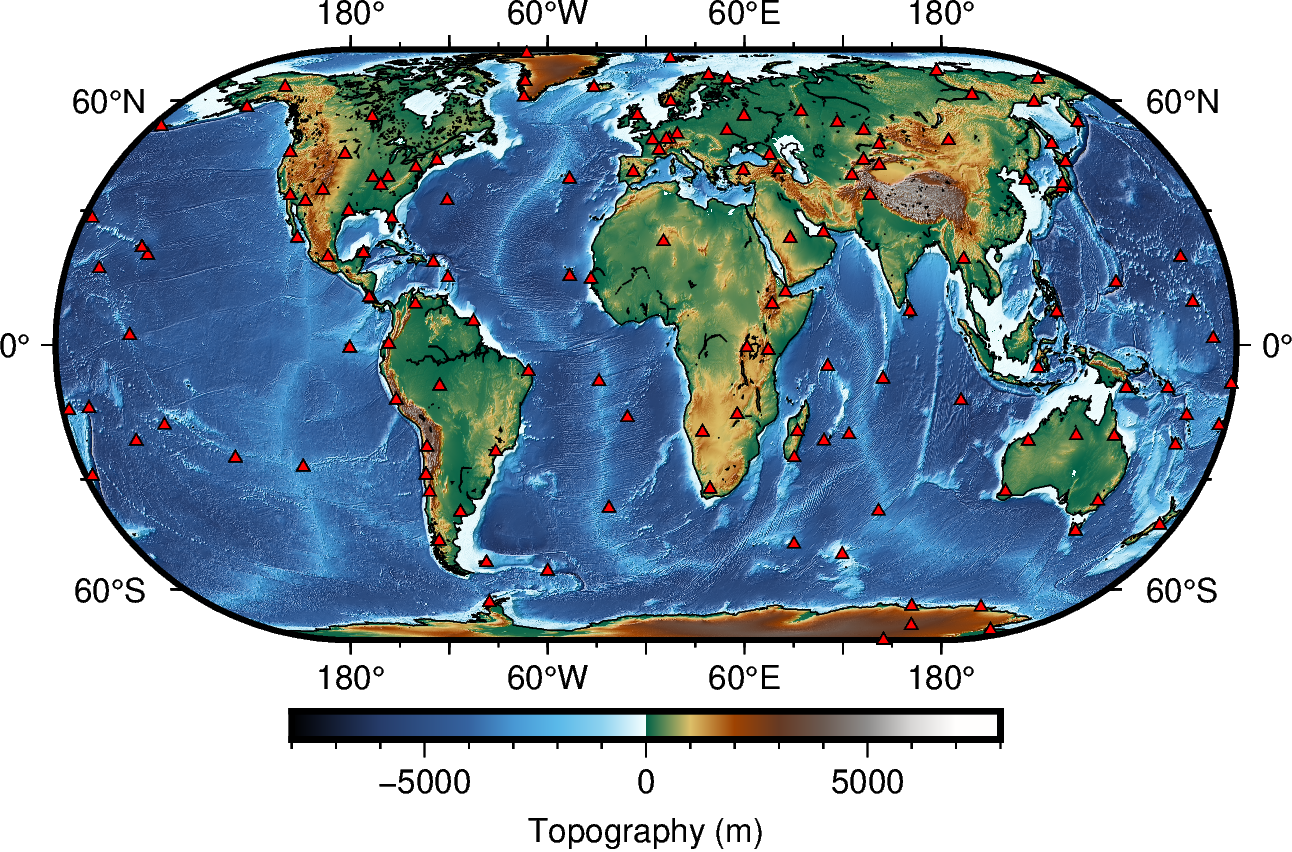

In [28]:
# config['plot_station']="AIS"

fig = __makeplot_map(config, stations, station_names=True)

In [29]:
# fig.savefig(config['outdir_figures']+"station_map"+".png", anti_alias=True, dpi=300, transparent=None)

Write station coordinates to csv file

In [ ]:
stations.to_csv(config['outdir']+"station_coordinates.csv")